In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet
import statsmodels.api as sm

from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot


In [95]:
data = pd.read_csv('data.csv')
data_frame = data.copy()
df = data.copy()
data_f = data.copy()
X = data.Time
Y = data.Value

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))
data.head(5)

Number of datapoints in the Dataset: 82559
Minimum date from data set: 2012-01-01 00:00:00
Maximum date from data set: 2021-06-01 23:00:00


,Time,Value
0,2012-01-01 00:00:00,25.12
1,2012-01-01 01:00:00,23.64
2,2012-01-01 02:00:00,19.03
3,2012-01-01 03:00:00,15.97
4,2012-01-01 04:00:00,15.90


In [96]:
# unit: €/MWh
data.describe()

,Value
count,82560.000000
mean,36.401464
std,17.143671
min,-221.990000
25%,27.107500
50%,35.360000
75%,45.910000
max,210.000000


In [97]:
data = data.set_index('Time')
data.index = pd.to_datetime(data.index)

In [98]:
data_res = data.resample('1W').mean()

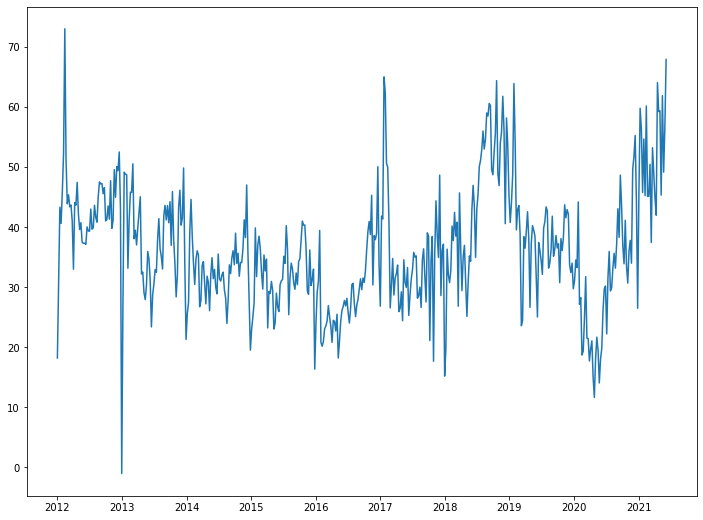

In [99]:
x = data_res.index
y = data_res.Value

plt.figure(figsize=(12, 9))
plt.plot(x,y)
plt.show()

## Prophet on whole data set + future data set

In [100]:
#switch column names to prophet structure
data_frame.rename(columns = {'Time': 'ds', 'Value': 'y'}, inplace = True)

In [101]:
pro = Prophet()
pro.add_country_holidays(country_name='Germany')
pro.fit(data_frame)

In [102]:
future = pro.make_future_dataframe(periods = 300)

In [103]:
forecast = pro.predict(future)

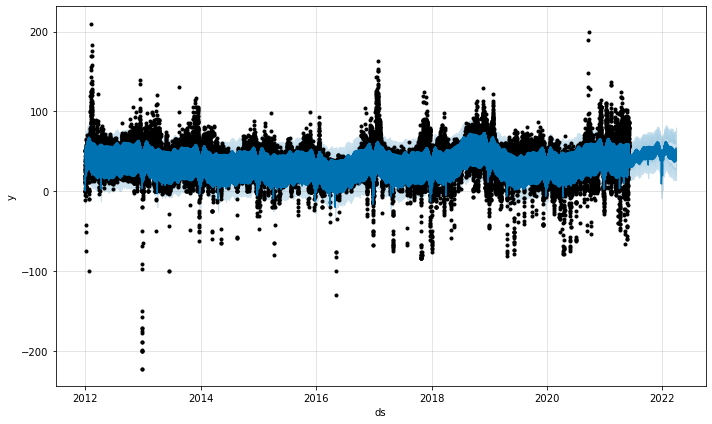

In [104]:
fig = pro.plot(forecast)

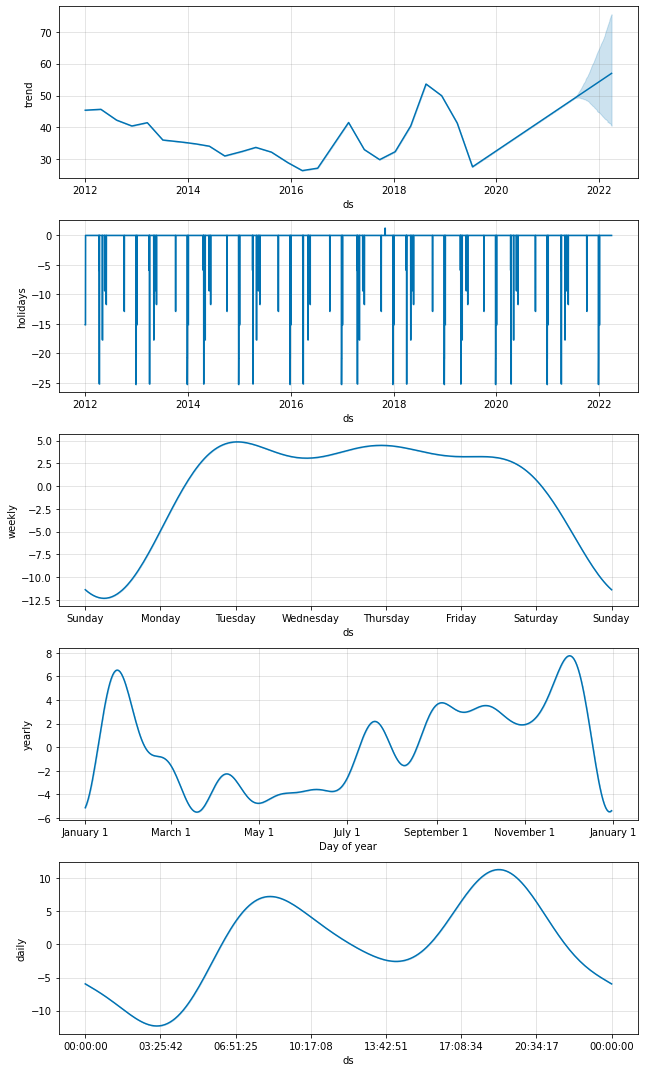

In [48]:
# components the model uses for prediction 
fig = pro.plot_components(forecast)

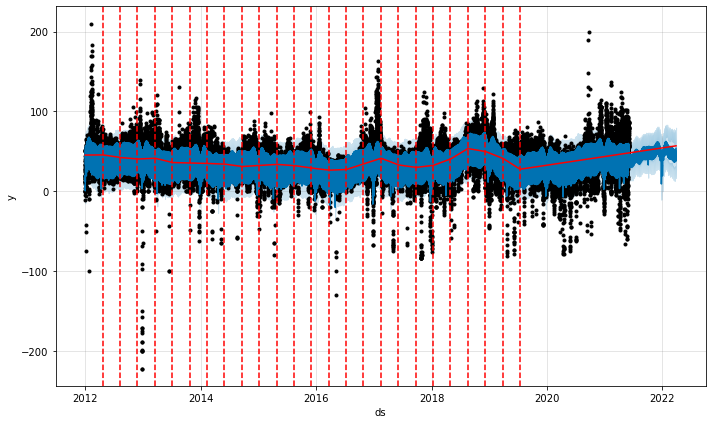

In [49]:
fig = pro.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro, forecast) 

In [50]:
pro.changepoints

2642    2012-04-20 02:00:00
5284    2012-08-08 04:00:00
7926    2012-11-26 06:00:00
10568   2013-03-16 08:00:00
13209   2013-07-04 09:00:00
15851   2013-10-22 11:00:00
18493   2014-02-09 13:00:00
21135   2014-05-30 15:00:00
23777   2014-09-17 17:00:00
26419   2015-01-05 19:00:00
29061   2015-04-25 21:00:00
31703   2015-08-13 23:00:00
34344   2015-12-02 00:00:00
36986   2016-03-21 02:00:00
39628   2016-07-09 04:00:00
42270   2016-10-27 06:00:00
44912   2017-02-14 08:00:00
47554   2017-06-04 10:00:00
50196   2017-09-22 12:00:00
52838   2018-01-10 14:00:00
55479   2018-04-30 15:00:00
58121   2018-08-18 17:00:00
60763   2018-12-06 19:00:00
63405   2019-03-26 21:00:00
66047   2019-07-14 23:00:00
Name: ds, dtype: datetime64[ns]

## Prophet on part of the data set

In [107]:
df = data_frame.copy()
x = 10000
d = 24 * 7
df_train = df[:x]
df_test = df[x:(x + d)].drop(['y'], axis = 1)
df_train.size 

20000

In [53]:
prophet = Prophet()
prophet.add_country_holidays(country_name='Germany')
prophet.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


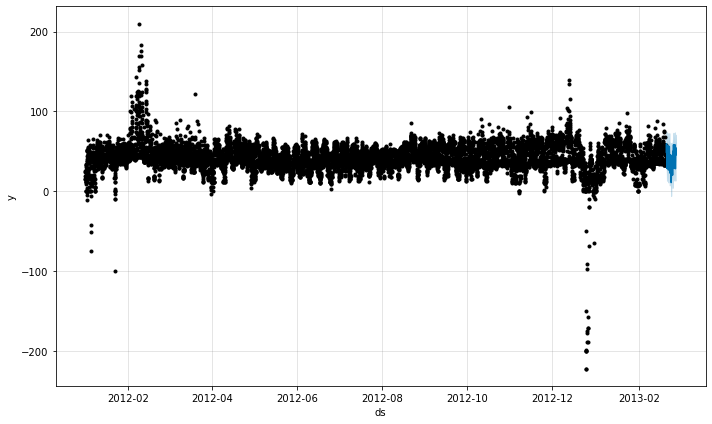

In [54]:
forecast = prophet.predict(df_test)
fig = prophet.plot(forecast)

In [55]:
y_true = df['y'][x:x+d].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 7.968


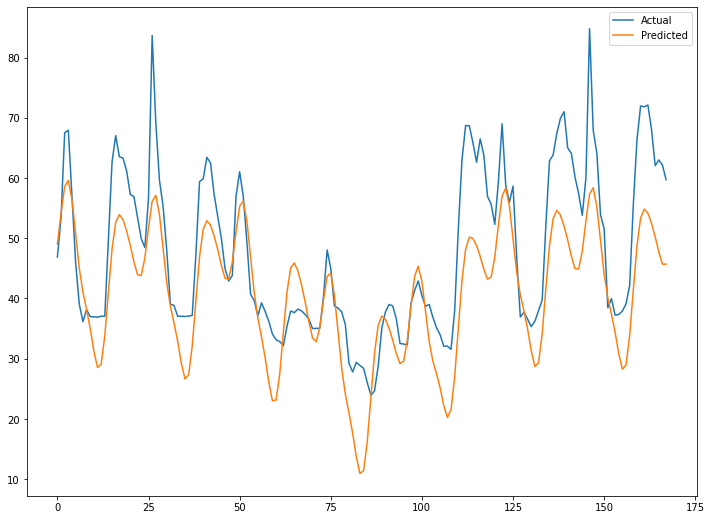

In [56]:
plt.figure(figsize=(12, 9))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

## MAPE

In [68]:
def walk_forward_validation(data, min_train):    
    
    predictions = np.array([])
    mape_list = []
    train, test = data[:min_train], data[min_train:min_train+1]
    
    for i in range(min_train,len(data)-1):
        print('Index i: {}'.format(i))
        print('Last Train Value: {}'.format(train[-1]))
        print('Test Value: {}'.format(test))
        prophet = Prophet()
        prophet.add_country_holidays(country_name='Germany')
        prophet.fit(train)
        
        # Forecast daily loads for week i
        forecast = prophet.predict(len(train)+1,len(train)+1)
        print('Predicted Value: {}'.format(forecast))
        predictions = np.concatenate((predictions, forecast),axis=None)
        # Calculate MAPE and add to mape_list
        mape_score = (abs(test-predictions[-1])/test)*100
        print('MAPE Score: {}'.format(mape_score))
        mape_list.append(mape_score)
        print('--------------')
        
        # Adjust Training and Test Data for Next Loop
        train = data[:i+1]
        if i != len(data)-2:
            test = data[i+2]
        
    return predictions, mape_list

In [69]:
data

,Time,Value
0,2012-01-01 00:00:00,25.12
1,2012-01-01 01:00:00,23.64
2,2012-01-01 02:00:00,19.03
3,2012-01-01 03:00:00,15.97
4,2012-01-01 04:00:00,15.90
...,...,...
82555,2021-06-01 19:00:00,86.70
82556,2021-06-01 20:00:00,85.14
82557,2021-06-01 21:00:00,80.50
82558,2021-06-01 22:00:00,75.31


In [81]:
data_hourly = data_f.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')
#switch column names to prophet structure
data_hourly.rename(columns = {'Time': 'ds', 'Value': 'y'}, inplace = True)

In [87]:
data_all = data_hourly.y[:-1]
data_5a = data_hourly.y[38735:-1]
data_1a = data_hourly.y[73799:-1]
data_6m = data_hourly.y[-4369:-1]
data_3m = data_hourly.y[-2209:-1]
data_1m = data_hourly.y[-745:-1]
data_3w = data_hourly.y[-505:-1]
data_2w = data_hourly.y[-337:-1]
data_1w = data_hourly.y[-169:-1]
data_5d = data_hourly.y[-121:-1]
data_4d = data_hourly.y[-97:-1]
data_3d = data_hourly.y[-73:-1]
data_2d = data_hourly.y[-49:-1]
data_1d = data_hourly.y[-25:-1]
data_1w.rename(columns = {'Time': 'ds', 'Value': 'y'}, inplace = True)

TypeError: rename() got an unexpected keyword argument 'columns'

In [85]:
pred, mape = walk_forward_validation(data_1w, 27)

Index i: 27
Last Train Value: 58.15
Test Value: 2021-05-27 02:00:00    56.37
Freq: H, Name: y, dtype: float64


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [108]:
from fbprophet.diagnostics import cross_validation
prophet = Prophet()
prophet.add_country_holidays(country_name='Germany')
prophet.fit(df_train)
df_cv = cross_validation(prophet, initial='100 days', period='10 days', horizon = '5 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 32 forecasts with cutoffs between 2012-04-11 15:00:00 and 2013-02-15 15:00:00


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [93]:
import fbprophet
fbprophet.__version__

'0.7.1'